## Models on best vs Full Features
---

### Objective:

- Prove that the best features are enough to achieve a good performance. and all features introduce noise.

#### Findings:

- Sampling Rate: 4000 Hz
- Extraction Interval: 2 s
- Balancing Type: Both (priori and posteriori)
- Selected Features:

	| Type                | N° Features |
	| ------------------- | ---------- |
	| MFCC                | 30         |
	| CQT                 | 70         |
	| Chroma              | 12         |
	| RMS                 | 40         |
	| Zero Crossing Rates | 40         |
	| Spectral Centroid   | 40         |
	| Spectral Bandwidth  | 60         |
	| Spectral Rolloff    | 40         |

In [16]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,balanced_accuracy_score
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-paper")
import seaborn as sns

sns.set_theme(context="paper", font_scale=1)

In [17]:
# set the paths
BASE_DIR = "../../dataset/"

# features
FEATURES_BASE = "../../features/"
#FEATURES = FEATURES_BASE + 'balanced/posteriori/'
FEATURES = FEATURES_BASE + 'raw/'

# Models
MODELS = "../../models/"
MODELS_RESULTS = MODELS + "results/"

# report
PAPER = "../../paper/"
IMAGES_PATH = PAPER + "images/"

# HYERPARAMETERS
SEED = 42
INTERVAL = 1

BALANCING_TYPE = "none"
RESULT_NAME = f"feature_types_comparison_{BALANCING_TYPE}.csv"
CM_NAME = f"confusion_matrix_models_comparison_best_features_{BALANCING_TYPE}.npy"


In [18]:
# -----------------------------------------Constants-----------------------------------------
full_data_dict_keys = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
interval = INTERVAL  # You need to define INTERVAL somewhere
sample_rates = [4000]
filtered_feats = {
    "30 MFCC": "28mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "0cqt",
    "40 RMS": "0rms",
    "40 Zero Crossing Rates": "1zcr",
    "40 Spectral Centroid": "0sc",
    "60 Spectral Bandwidth": "0sb",
    "40 Spectral Rolloff": "0sr",
}
all_feats = {
    "30 MFCC": "30mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "70cqt",
    "40 RMS": "41rms",
    "40 Zero Crossing Rates": "41zcr",
    "40 Spectral Centroid": "41sc",
    "60 Spectral Bandwidth": "61sb",
    "40 Spectral Rolloff": "41sr",
}
FILTERED_NAME = (
    f"full_data_filtered_{INTERVAL}s_4000hz_"
    + "_".join(numvalue for _, numvalue in filtered_feats.items())
    + ".npy"
)
FULL_NAME = (
    f"full_data_none_bal_{INTERVAL}s_4000hz_"
    + "_".join(numvalue for _, numvalue in all_feats.items())
    + ".npy"
)

FILE_NAMES = {"full": FULL_NAME, "filtered": FILTERED_NAME}

### MODEL TRAINING
| Name        | Label |
| ----------- | ----- |
| artifacts   | 0     |
| extrahls    | 1     |
| murmurs     | 2     |
| normals     | 3     |
| extrastoles | 4     |

In [19]:
# ----------------------------------------- Create DataFrame to store results-----------------------------------------
class_weights = {0: 1.0, 1: 5, 2: 5, 3: 1, 4: 5}

MODELS = {
    "Random Forest": RandomForestClassifier(
        random_state=SEED, class_weight=class_weights
    ),
    "XGBoost": XGBClassifier(random_state=SEED, class_weights=class_weights),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(
            512,
            256,
            128,
            64,
            32,
        ),
        activation="relu",
        solver="adam",
        random_state=SEED,
    ),
    "CatBoost": CatBoostClassifier(
        random_state=SEED, verbose=0, class_weights=class_weights
    ),
}

METRICS = {
    "Test Acc": accuracy_score,
    "Macro F1": f1_score,
    "Balanced Accuracy": balanced_accuracy_score,
}

result_df = pd.DataFrame(columns=list(METRICS.keys()), index=list(FILE_NAMES.keys()))
cm_dict = {}

# ----------------------------------------- Loop over each feature-----------------------------------------
for feature_type, file_name in FILE_NAMES.items():
    print(f"Feature type {feature_type}")
    full_data = np.load(FEATURES + file_name, allow_pickle=True).item()
    n_cols = full_data["train"]["X"].shape[1]
    # Extract data from the dictionary
    X_train = full_data["train"]["X"]
    y_train = full_data["train"]["y"]
    X_test = full_data["test"]["X"]
    y_test = full_data["test"]["y"]

    clf = MODELS["MLP"]
    # fit the model
    clf.fit(X_train, y_train)

    for metric, funct in METRICS.items():
        print(f"\tCalculating {metric}")
        y_pred = clf.predict(X_test)

        if "Macro" in metric:
            result_df.loc[feature_type, metric] = funct(y_test, y_pred, average="macro")
        else:
            result_df.loc[feature_type, metric] = funct(y_test, y_pred)
        # cf
        cf = confusion_matrix(y_test, y_pred)
        cm_dict[feature_type] = cf

# ----------------------------------------- Save the results-----------------------------------------
result_df.to_csv(MODELS_RESULTS + RESULT_NAME)
np.save(MODELS_RESULTS + CM_NAME, cm_dict)
result_df

Feature type full
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy
Feature type filtered
	Calculating Test Acc
	Calculating Macro F1
	Calculating Balanced Accuracy


,Test Acc,Macro F1,Balanced Accuracy
full,0.716189,0.505955,0.496928
filtered,0.856557,0.78376,0.774887


(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'Test Acc'),
  Text(0, 1.5, 'Macro F1'),
  Text(0, 2.5, 'Balanced Accuracy')])

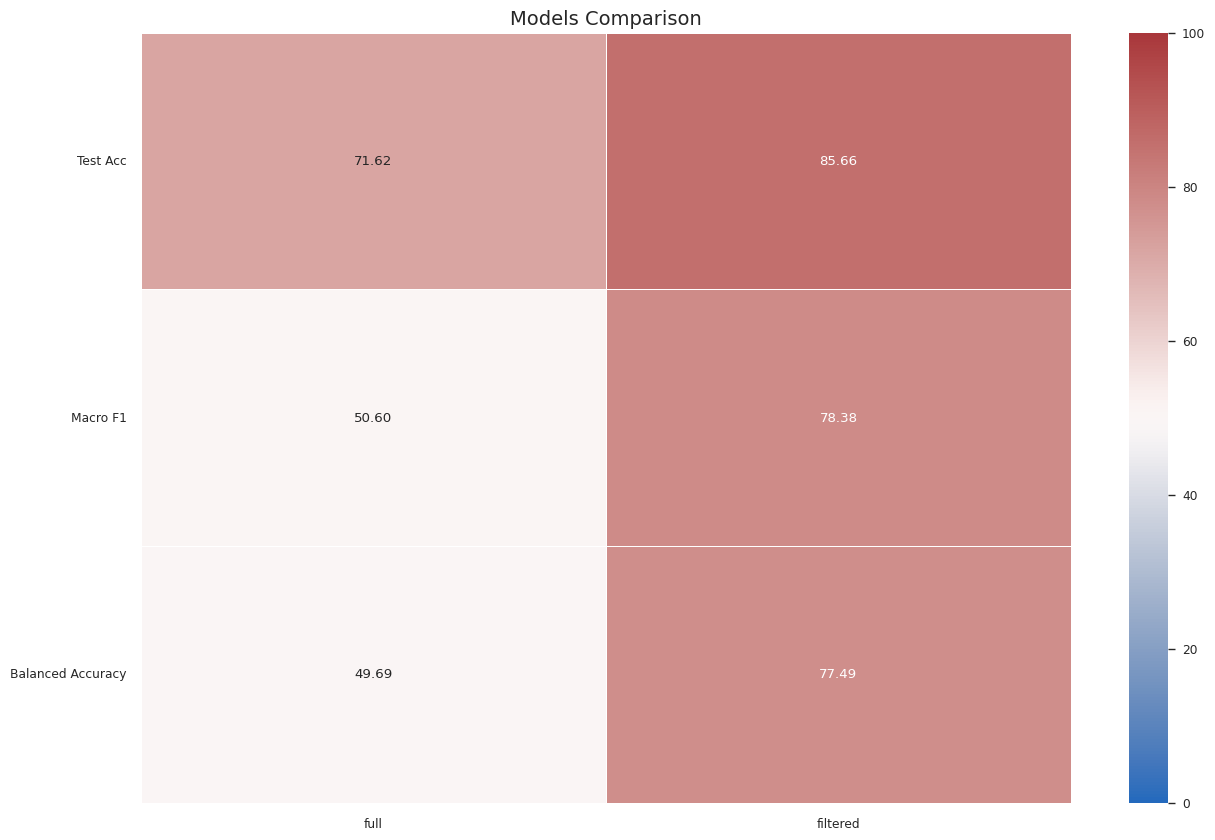

In [36]:
result_df = pd.read_csv(MODELS_RESULTS + RESULT_NAME, index_col=0).transpose()

plt.figure(figsize=(15, 10))
sns.set_theme(context="paper", font_scale=1)

sns.heatmap(result_df.astype(float) * 100, annot=True, cmap="vlag", fmt=".2f",vmax=100,vmin=0,linewidths=0.5)
#plt.title("Accuracy (%)", fontsize=14)
plt.title("Models Comparison", fontsize=14)
plt.yticks(rotation=0)

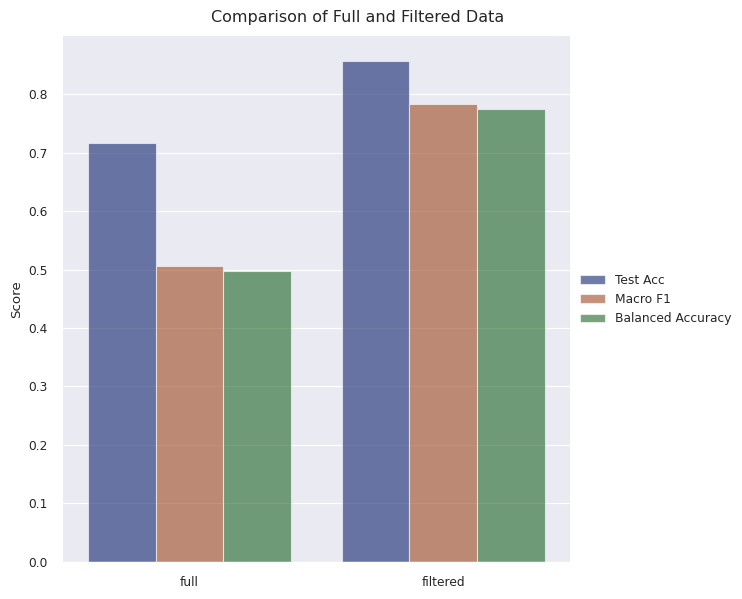

In [38]:
result_df.reset_index(inplace=True)

df_melted = pd.melt(
    result_df,
    id_vars=["index"],
    value_vars=["full", "filtered"],
    var_name="Type",
    value_name="Value",
)
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_melted,
    kind="bar",
    x="Type",
    y="Value",
    hue="index",
    errorbar="sd",
    palette="dark",
    alpha=0.6,
    height=6,
)
g.despine(left=True)
g.fig.suptitle("Comparison of Full and Filtered Data", y=1.02)  # Adding title
g.set_axis_labels("", "Score")
g.legend.set_title("")